## Gaussian Mixture Regression (GMR) 

In [2]:
import sys
sys.path.append('../lib')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from mixture_model import *
from plot_utils import *
from scipy.stats import norm as normal_dist

from matplotlib.patches import Polygon

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Using GMR for the letter data

The letter data consists of two variables, $x_{1,t}$ and $x_{2,t}$ that moves for $T$ time steps. 

Without loss of generality, we assume that the movement begins at time $t=0$ and ends at time $t=1$. 

In this demo, we want to approximate the function $f(t)$:
$$f(t) = [x_{1,t},x_{2,t}]$$
using GMR. In other words, given the current time $t$ we want to predict the location of $[x_{1,t},x_{2,t}]$.

Since the problem is nonlinear, we also expand the input $t$ polynomially, i.e. instead of using $t$ as input, we use $[1, t, t^2]$. 

GMR formulates the regression problem by estimating the joint probability distribution of the input and output (concatenated as a single vector). For the prediction, we condition this joint probability distribution w.r.t. the input.  

### Declare Variables 

In [3]:
n_states = 6 #number of states in the GMM
poly_deg = 2 #Degree of the polynomial for the input
n_out = 2 #number of motion variables
n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

t_in = np.linspace(0,1,n_data) #time along the trajectory

### Load Data 

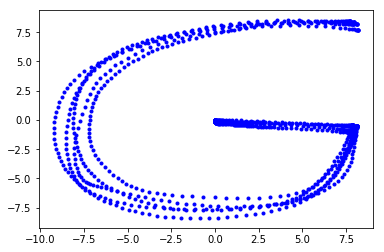

In [4]:
ROOT = '../python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')
colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]


#### Plot the data for each dimension against the time 

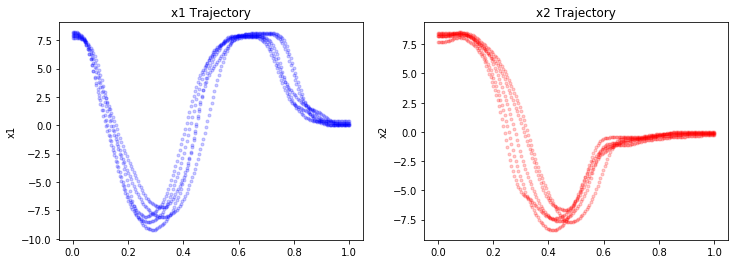

In [5]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)
ax[0].set_title('x1 Trajectory')
ax[0].set_ylabel('t')
ax[0].set_ylabel('x1')
ax[1].set_title('x2 Trajectory')
ax[1].set_ylabel('t')
ax[1].set_ylabel('x2')

for data_i in data:
    ax[0].plot(t_in, data_i[:,0],'.b',alpha=0.2)
    ax[1].plot(t_in, data_i[:,1],'.r',alpha=0.2)

### Input Formulation for GMR
We need to formulate what we use as the input to GMR 

#### Option 1: Use time as the direct input 

In [6]:
#input
Xt = t_in[:,None]

#prepare joint data variable
data_joint = np.zeros((data.shape[0], data.shape[1], data.shape[2]+1))

#### Option 2: Expand the input using polynomial expansion 

#### Concatenate the input (x) to the output ([$x_1,x_2$]) 

In [7]:
for i in range(n_samples):
    data_joint[i] = np.hstack([Xt, data[i]])
    
#concatenate the whole samples
data_joint = np.concatenate(data_joint,axis=0)
D = data_joint.shape[1]

### Estimate GMM using the joint data of input and output 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Text(0.5,1,'The output components of the joint distribution')

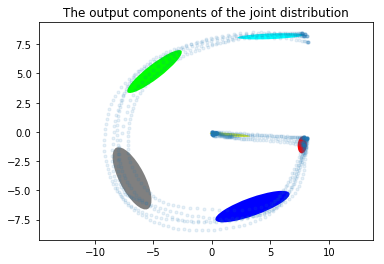

In [8]:
gmm = GMM(D=D,K=n_states,M=1,N=1000)
gmm.fit(data_joint)
clear_output()

#plot only the output components (the last two dimensions)
fig, ax = plt.subplots(figsize = (6,4))
plot_GMM(gmm.means_[:,-2:], gmm.covariances_[:,-2:,-2:],ax,colors=colors)
plt.axis([-13,10,-20,20])
plt.plot(data_joint[:,-2],data_joint[:,-1], '.' ,alpha=0.1)
plt.axis('equal')
plt.title('The output components of the joint distribution')

### Create a GMR instance based on the GMM 

We can do GMR also with the GMM class directly, by using the condition() function. This GMR class is created for faster computation, because if the input and output indices of the GMM has been defined, some of the pre-computation can be done only once (e.g. the predicted output covariance does not depend on the input, so we can compute this in advance). 

In [9]:
#use slice() to define the indices of input and output of GMR
n_in = Xt.shape[1]
n_out = 2
dim_in = slice(0,n_in)
dim_out = slice(n_in, n_in+n_out)
gmr = GMR(gmm, dim_in, dim_out)

#### Predict the data based on the time input

In [10]:
y_preds = []
covs = []
for x in Xt:
    y,cov = gmr.predict(x)
    y_preds.append(y)
    covs.append(cov)
    
y_preds = np.array(y_preds)
covs = np.array(covs)

#### Plot data 

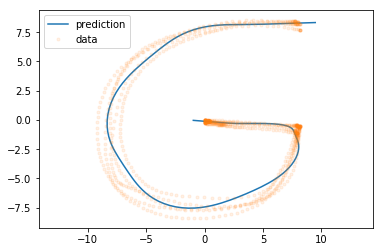

In [11]:
plt.plot(y_preds[:,0], y_preds[:,1], '-', label='prediction')
plt.axis([-13,10,-20,20])
plt.plot(data_joint[:,-2],data_joint[:,-1], '.' ,alpha=0.1, label='data')
plt.axis('equal')
plt.legend()
plt.show()

### Plotting the output distribution 

While LWR only provide a specific value(s) as the output, GMR can predict the output probability distribution. 
If you set 'return_gmm = True' in the predict() function, the output distribution is a mixture of Gaussians. 
If you set 'return_gmm = False', the output distribution is a single Gaussian distribution. This is obtained by doing a moment-matching of the original mixture of Gaussians.

#### Plot each dimension separately 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


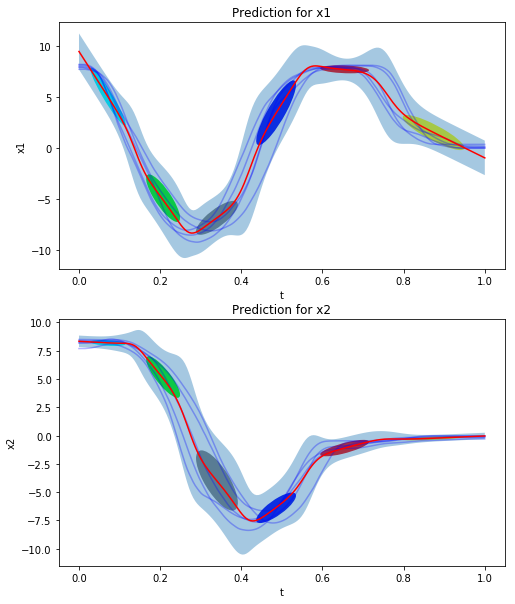

In [12]:
fig = plt.figure(figsize=(8,10))


#Plot the prediction for x1
ax = plt.subplot(2,1,1)
ax.set_title('Prediction for x1')
ax.set_xlabel('t')
ax.set_ylabel('x1')
plot_GMM(gmm.means_[:,0:2], gmm.covariances_[:,:2,:2], ax, colors=colors)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,0], '-b',alpha = 0.3)
#plot covariances
y_covs1 = covs[:,0,0]
plot_with_covs_1D(t_in, y_preds[:,0],y_covs1, ax)


#Plot the prediction for x2
ax = plt.subplot(2,1,2)
ax.set_title('Prediction for x2')
ax.set_xlabel('t')
ax.set_ylabel('x2')
plot_GMM(gmm.means_[:,0::2], gmm.covariances_[:,::2,::2], ax, colors=colors)
for i in range(n_samples):
    plt.plot(t_in, data[i,:,1], '-b',alpha = 0.3)
#plot covariances
y_covs2 = covs[:,1,1]
plot_with_covs_1D(t_in, y_preds[:,1],y_covs2, ax)
plt.show()

#### Plot the spatial prediction distribution (without time)

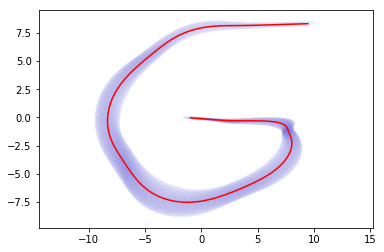

In [17]:
fig,ax = plt.subplots()
for i in range(n_data):
    mu = y_preds[i,:]
    sigma = covs[i]
    plot_gaussian_2D(mu,sigma,ax,alpha=0.03, color=[0,0,0.8])
plt.axis([-13,10,-20,20])
plt.axis('equal')
plt.plot(y_preds[:,0], y_preds[:,1], 'r')